In [40]:
from itertools import chain
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [6]:
true_df = pd.read_csv('D://Freelance/fake_news_classification/True.csv')
fake_df = pd.read_csv('D://Freelance/fake_news_classification/Fake.csv')

In [7]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [10]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [11]:
true_df['target'] = 1 
fake_df['target'] = 0 

In [12]:
combined_data = pd.concat([true_df, fake_df], ignore_index=True, sort=False) # Объеденяю данные

Text(0.5, 1.0, 'Data distribution of fake and true data')

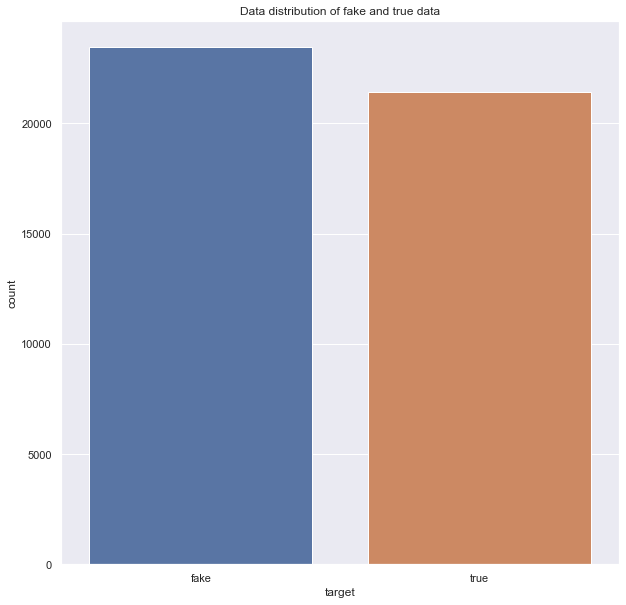

In [14]:
plt.figure(figsize=(10, 10))
sns.set(style="darkgrid")
ax = sns.countplot(x="target", data=combined_data)
ax.set(xticklabels=['fake', 'true'])
plt.title("Data distribution of fake and true data")

In [15]:
def clean_train_data(x):
    text = x
    text = text.lower() # слова в нижний регистр
    text = re.sub('\[.*?\]', '', text) # удаление квадратных скобок
    text = re.sub(r'[^\w\s]','',text) # удаление пунктуации
    text = re.sub('\w*\d\w*', '', text) # удаление слов, содержащих числа
    text = re.sub(r'http\S+', '', text) # удаление ссылок
    text = re.sub('\n', '', text)
    return text

In [16]:
clean_combined_data = combined_data.copy()
clean_combined_data['text'] = combined_data.text.apply(lambda x : clean_train_data(x))

In [17]:
clean_combined_data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters the head of a conservative...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people will be...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters the special counsel invest...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geo...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,seattlewashington reuters president donald tr...,politicsNews,"December 29, 2017",1


In [18]:
sw = nltk.corpus.stopwords.words("english")

In [23]:
def remove_eng_stopwords(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [word for word in token_text if word not in sw]
    add_text = ' '.join(remove_stop)
    return add_text

In [24]:
stopword_combined_data = clean_combined_data.copy()
stopword_combined_data['text'] = clean_combined_data.text.apply(lambda x : remove_eng_stopwords(x))

In [26]:
list_words = stopword_combined_data['text'].str.split()
list_words_merge = list(chain(*list_words))
d = Counter(list_words_merge)
df = pd.DataFrame(data=d, index=['count'])
top_common_words = df.T.sort_values(by=['count'], ascending=False).reset_index().head(50)
top_common_words.head()

,index,count
0,said,130051
1,trump,115869
2,us,63100
3,would,54929
4,president,51005


In [28]:
lemm = WordNetLemmatizer()

In [29]:
def word_lemmatizer(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [lemm.lemmatize(w) for w in token_text]
    add_text = ' '.join(remove_stop)
    return add_text

In [30]:
lemmatize_data = stopword_combined_data.copy()
lemmatize_data['text'] = stopword_combined_data.text.apply(lambda x : word_lemmatizer(x))
lemmatize_data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters head conservative republica...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people allowed ...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters special counsel investigati...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,seattlewashington reuters president donald tru...,politicsNews,"December 29, 2017",1


In [31]:
string = ' '.join(lemmatize_data['text'])
str_val = string.split(" ")

In [32]:
model = stopword_combined_data.copy()

In [34]:
model['combine_text'] = model['subject'] + " " + model['title'] + " " + model['text']
del model['title']
del model['subject']
del model['date']
del model['text']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(model['combine_text'], model['target'], random_state=0)

In [39]:
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

In [51]:
model_knn = KNeighborsClassifier(n_neighbors=2)
model_knn.fit(X_vec_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [52]:
predicted_value = model_knn.predict(X_vec_test)

In [53]:
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.8321667419531992
